# free vibrations of a cantilever beam

Demonstration of the calculation method, using the 2D beam element. The addition over the single-element derivation is that multiple beams are used, but since the geometry is still in the X-Y plane and the beams are not rotated, the only thing to do is to
a) add more elements
b) assemble the global stiffness, and mass matrices utilizing the same techniques as in Chapter 4, e.g. Example 4.2.


In [1]:
# number of elements to be used. The book uses 10.
NE = 10  # number of elements

# number of degrees of freedom each node
ND = 2  # 2D problem, so only X and Y coordinates are used

# number of degrees of freedom per element. This is not to be changed.
DOF = 4  # u_x, u_y, u_z, θ_y, θ_z


In [2]:
# imports
import numpy as np
import scipy as sp
from source.OneD.node import Node
from source.OneD.beam.beam import BeamElement, BeamModel
np.set_printoptions(precision=2, threshold=3, suppress=False)

### Geometry and material properties

Defined as in the book and converted to SI units for consistency.

In [3]:
b = 0.1  # width of the beam [m]
h = 0.1  # height of the beam [m]
L = 5  # length of the beam [m]
E = 210e6  # Young's modulus [N/m2]
nu = 0.3  # Poisson's ratio
ro = 8000  # density [kg/m³]

### Cross sectional properties

In [4]:
A = b * h  # cross-sectional area [m²]
Iy = b * h**3 / 12  # second moment of area around the y-axis [m^4]
Iz = h * b**3 / 12  # second moment of area around the z-axis [m^4]

### Analytical solutions for a cantilever beam

In [5]:
### Analytical solutiuons
f1 = 1.875 ** 2 * np.sqrt(E * Iy / (ro * A * L ** 4)) / (2 * np.pi)  # first natural frequency [Hz]
f2 = 4.694 ** 2 * np.sqrt(E * Iy / (ro * A * L ** 4)) / (2 * np.pi)  # second natural frequency [Hz]
f3 = 7.855 ** 2 * np.sqrt(E * Iy / (ro * A * L ** 4)) / (2 * np.pi)  # third natural frequency [Hz]

### FE mesh and supports.

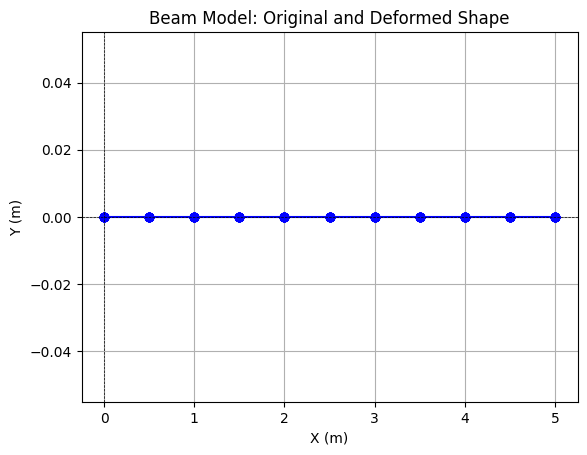

In [6]:
# Mesh
# The total length of the beam is divided into NE elements, each element has a length of L/NE.
mesh = np.linspace(0, L, NE + 1)  # mesh points along the beam

# Create nodes based on the mesh
nodes = tuple(Node(x, 0, None) for x in mesh)  # nodes in the X-Y plane, Z=0

# Create beam elements. The inertia to be used is the second moment of area around the y-axis.
elements = [(nodes[i].ID, nodes[i + 1].ID, A, Iy, E, ro) for i in range(NE)]

# supports: left end is clamped.
supports = {0: (0, 1)}

model = BeamModel(nodes_=nodes, elements_=elements, supports_=supports)

model.plot_model(u=None)

### Solving the model for a vertical load at the free end

This is just to show that the model is working correctly.

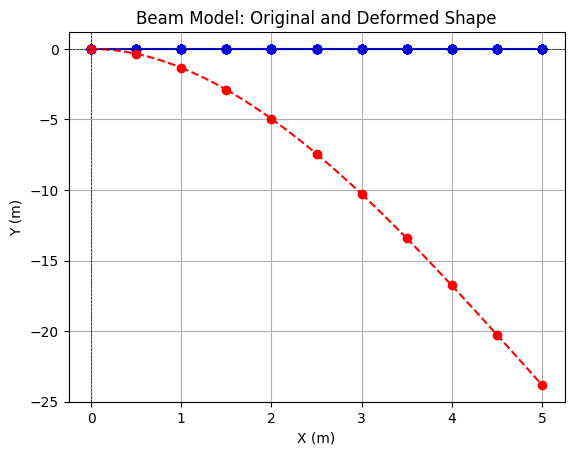

In [7]:
_F = np.zeros((len(model.nodes) * ND, 1))  # global force vector
_F[-2] = -1000  # 1 kN
u, r = model.solve(_F)
model.plot_model(u)

### Solving the generalized eigenvalue problem to get the natural frequencies and mode shapes

The Euler beam is usually stiffer than the analytical solution and also the modal masses are smaller, so all values are expected to be higher than the analytical solution.


1. mode shape: 0.1208 Hz
   analytical solution: 0.1047 Hz
   ratio to the analytical solution: 0.8662622313977109

2. mode shape: 0.7463 Hz
   analytical solution: 0.6561 Hz
   ratio to the analytical solution: 0.8790807910851934

3. mode shape: 2.0579 Hz
   analytical solution: 1.8372 Hz
   ratio to the analytical solution: 0.8927443062337438

4. mode shape: 3.9623 Hz

5. mode shape: 6.4245 Hz


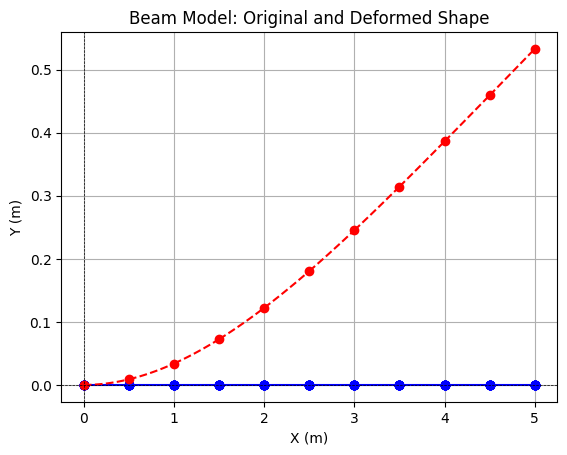

In [8]:
freqs, shapes = model.solve_modal()  # returns the frequencies and the mode shapes

fi = (f1, f2, f3)
for ind, freq in enumerate(freqs[:5]):
    print()
    print(f'{ind+1}. mode shape: {freq:.4f} Hz')
    if ind < 3:
        print(f'   analytical solution: {fi[ind]:.4f} Hz')
        print(f'   ratio to the analytical solution: {fi[ind] / freq}')

model.plot_model(u=shapes[:, 0])

# Now doing the same for a 3D beam

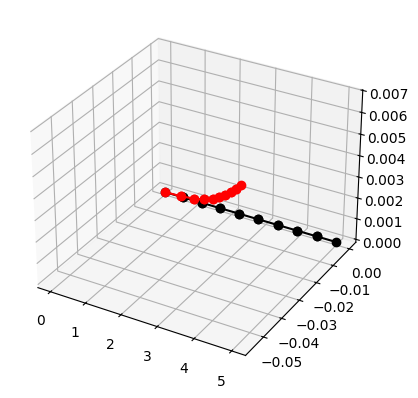

0 3D: 0.12069315094184373 == 0 2D: 0.12083905440541749
1 3D: 0.12069315094258981 == 0 2D: 0.12083905440541749
2 3D: 0.7429084981465739 == 1 2D: 0.7462967219367133
3 3D: 0.7429084981467267 == 1 2D: 0.7462967219367133
4 3D: 2.0416397194356595 == 2 2D: 2.057877143452584
5 3D: 2.041639719435752 == 2 2D: 2.057877143452584
6 3D: 3.916680606720115 == 3 2D: 3.9622568630635158
7 3D: 3.916680606720123 == 3 2D: 3.9622568630635158
9 3D: 6.326100824897991 == 4 2D: 6.424523519312381
10 3D: 6.326100824898004 == 4 2D: 6.424523519312381


In [23]:
from source.OneD.frame.spatial_frame import SpatialFrameModel
from source.OneD.node import IDMixin

IDMixin.reset()

meshx = np.linspace(0, L, NE)
nodes = tuple(Node(x, 0, 0) for x in meshx)

spatial_model = SpatialFrameModel(
    nodes_=nodes,
    elements_=tuple((x.ID, y.ID, A, Iy, Iz, 1, E, ro, nu) for x, y in zip(nodes, nodes[1:])),
    supports_={nodes[0].ID: (0, 1, 2, 3, 4, 5), }
)

spatial_freqs, shapes = spatial_model.solve_modal()
spatial_model.plot_frame(shapes[:, 0])

# finding the same frequencies in the 2D and 3D solutions
for spindex, fr in enumerate(spatial_freqs[:20]):
    for twodindex, same in enumerate(freqs):
        if np.isclose(fr, same, atol=1e-1):
            print(spindex, '3D:', fr, '==', twodindex, '2D:', same)
